In [1]:
# !pip install pyFFTW

In [15]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
from scipy.signal import hann 
from pyfftw.interfaces import scipy_fftpack as fftw
import scipy.signal.windows as sigw

%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

In [16]:
os.getcwd()

'C:\\Users\\mgaz4900\\OneDrive - The University of Sydney (Staff)\\Wave Data\\Sydney BEBs\\PTs RBS Solo_Pittwater'

In [17]:
os.chdir('C:\\Users\\mgaz4900\\OneDrive - The University of Sydney (Staff)\\Wave Data\\Sydney BEBs\\PTs RBS Solo_Pittwater') 

## Load dataset

In [18]:
colnames=['timestamp','pressure(dbar)','sea_pressure(dbar)',
          'depth(m)','velocity(m/s)'] 

data = pd.read_csv("Great_Mackerel_124167_20230412_1309_red_blue.csv", encoding="ISO-8859-1", skiprows=11, names=colnames, header=None)
data = data.dropna()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data

,timestamp,pressure(dbar),sea_pressure(dbar),depth(m),velocity(m/s)
0,2023-01-31 18:00:00.000,11.322196,1.189696,1.180037,0.008953
1,2023-01-31 18:00:00.500,11.332768,1.200268,1.190523,0.007027
2,2023-01-31 18:00:01.000,11.339565,1.207065,1.197265,-0.003158
3,2023-01-31 18:00:01.500,11.331367,1.198867,1.189134,-0.021242
4,2023-01-31 18:00:02.000,11.314044,1.181544,1.171952,-0.029731
...,...,...,...,...,...
8179982,2023-03-21 11:00:34.000,10.015308,-0.117192,-0.116241,0.000652
8179983,2023-03-21 11:00:34.500,10.015159,-0.117341,-0.116388,-0.000094
8179984,2023-03-21 11:00:35.000,10.015553,-0.116947,-0.115998,-0.000996
8179985,2023-03-21 11:00:35.500,10.012671,-0.119829,-0.118856,-0.000728


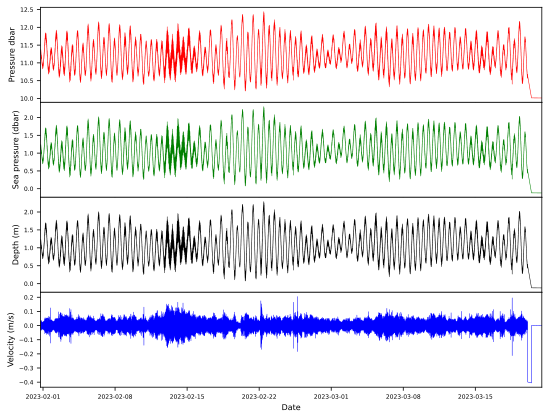

In [19]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(9,7), nrows=4, sharex=True, gridspec_kw={'hspace': 0})

ax0.plot(data.timestamp, data['pressure(dbar)'], lw=0.5, c='red')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Pressure dbar', fontsize=8)

ax1.plot(data.timestamp, data['sea_pressure(dbar)'], lw=0.5, c='green')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Sea pressure (dbar)', fontsize=8)

ax2.plot(data.timestamp, data['depth(m)'], lw=0.5, c='k')
ax2.tick_params(axis='both', which='major', labelsize=6)
ax2.set_ylabel('Depth (m)', fontsize=8)

ax3.plot(data.timestamp, data['velocity(m/s)'], lw=0.5, c='b')
ax3.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('Date', fontsize=8)
ax3.set_ylabel('Velocity (m/s)', fontsize=8)
# plt.xlim(0,len(data))
plt.xlim(data['timestamp'][0],data['timestamp'][len(data)-1])
plt.show()

## Select a time interval

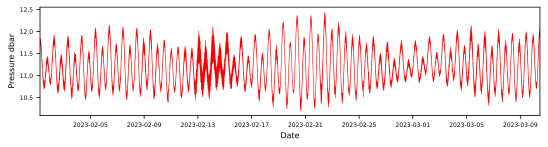

In [20]:
df_select = data[(data['timestamp']>='2023-02-01 6:00:00.000')&(data['timestamp']<='2023-03-10 11:00:34.000')].reset_index()

fig, ax0 = plt.subplots(figsize=(9,2), nrows=1, sharex=True, gridspec_kw={'hspace': 0})
ax0.plot(df_select['timestamp'], df_select['pressure(dbar)'], lw=0.5, c='red')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Pressure dbar', fontsize=8)
plt.xlabel('Date', fontsize=8)
plt.xlim(df_select['timestamp'][0],df_select['timestamp'][len(df_select)-1])
plt.show()

## Reshape data for spectral analyses

In [21]:
Hz = 2. # sample freq.
rl = 30 # minutes
dt = 1./Hz
bl = int((rl/dt)*60.) # burst length
nbl = int(math.floor(len(df_select)/bl))

# Reshape data
time = df_select.timestamp[0:nbl*bl].values.reshape((bl,nbl), order='F')
press = df_select['pressure(dbar)'][0:nbl*bl].values.reshape((bl,nbl), order='F')

mean_pressure = press.mean(axis=0)

## Define functions

In [33]:
def PT_power(x, dt, h=0):
    
    n = len(x)
    xd = mlab.detrend(x)
    
    if h > 0:
        #xd = xd*hann(n+2)[1:-1]
        xd = xd*sigw.gaussian(n+2, std=50)[1:-1]

    xn = fftw.fft(xd,n)
    if h > 0:
        xn = xn*np.sqrt(8/3)
        
    pxx = dt*(xn*np.conj(xn))/n
    
    paa = np.sqrt(xn*np.conj(xn))/n
    pxx = dt*(xn*np.conj(xn))/n
    
    nf= int(np.fix((n/2)+1))
    px=2.0 * pxx[0:nf]
    pa=2.0 * paa[0:nf]
    step = 1/(n*dt)
    f = np.arange(0, 1/(2.*dt)+step, step)[0:-1]
    
    return px, f, pa 

def Wwaves_spectral_RBR(px_in,f_in,dt):
    
    n21 = len(px_in)
    n = (n21-1)*2
    
    jj = np.argwhere((f_in>=0.33)&(f_in<1))[:,0]
    
    f = f_in[jj]
    px = px_in[jj]
    
    m0 = np.sum(px)/(n*dt)
    m1 = np.sum(f*px)/(n*dt);
    m2 = np.sum((f**2)*px)/(n*dt)
    m4 = np.sum((f**4)*px)/(n*dt)
    
    hs = 4.*np.sqrt(m0)
    hrms = np.sqrt(8.*m0)
    tm02 = np.sqrt(m0/m2)
    tm01 = m0/m1
    eps = np.sqrt(1.-(m2**2)/(m0*m4))
    hmax = 2.*hs
    
    ii = np.argwhere(f>=0.33)[:,0]
    fc = f[ii]
    pxc = px[ii]
    j = np.abs(pxc).argmax()
    tpeak = 1/fc[j]
    
    return hs, hrms, hmax, tm01, tm02, tpeak, eps


def Gwaves_spectral_RBR(px_in,f_in,dt):
    
    n21 = len(px_in)
    n = (n21-1)*2
    
    jj = np.argwhere((f_in>=0.05)&(f_in<0.33))[:,0]
    
    f = f_in[jj]
    px = px_in[jj]
    
    m0 = np.sum(px)/(n*dt)
    m1 = np.sum(f*px)/(n*dt);
    m2 = np.sum((f**2)*px)/(n*dt)
    m4 = np.sum((f**4)*px)/(n*dt)
    
    hs = 4.*np.sqrt(m0)
    hrms = np.sqrt(8.*m0)
    tm02 = np.sqrt(m0/m2)
    tm01 = m0/m1
    eps = np.sqrt(1.-(m2**2)/(m0*m4))
    hmax = 2.*hs
    
    ii = np.argwhere(f>=0.05)[:,0]
    fc = f[ii]
    pxc = px[ii]
    j = np.abs(pxc).argmax()
    tpeak = 1/fc[j]
    
    return hs, hrms, hmax, tm01, tm02, tpeak, eps 


def IGwaves_spectral_RBR(px_in,f_in,dt):
    
    n21 = len(px_in)
    n = (n21-1)*2
    
    jj = np.argwhere((f_in>=0.0033)&(f_in<0.05))[:,0]
    
    f = f_in[jj]
    px = px_in[jj]
    
    m0 = np.sum(px)/(n*dt)
    m1 = np.sum(f*px)/(n*dt);
    m2 = np.sum((f**2)*px)/(n*dt)
    m4 = np.sum((f**4)*px)/(n*dt)
    
    hs = 4.*np.sqrt(m0)
    hrms = np.sqrt(8.*m0)
    tm02 = np.sqrt(m0/m2)
    tm01 = m0/m1
    eps = np.sqrt(1.-(m2**2)/(m0*m4))
    hmax = 2.*hs
    
    ii = np.argwhere(f>=0.0033)[:,0]
    fc = f[ii]
    pxc = px[ii]
    j = np.abs(pxc).argmax()
    tpeak = 1/fc[j]
    
    return hs, hrms, hmax, tm01, tm02, tpeak, eps 

## Gravity (local wind) spectral wave parameters (1 to 3 s)

### Calculate spectral wave parameters

In [34]:
Wwave_time = []
Wwave_Hm0 = []
Wwave_Hrms = []
Wwave_Hmax = []
Wwave_Tm02 = []
Wwave_Tm01 = []
Wwave_Tpeak = []
Wwave_eps = []
Wwave_s = []
Wwave_fspec = []

for k in range(nbl):
    
    p = PT_power(press[:,k],dt,1) 
    out = Wwaves_spectral_RBR(p[0],p[1],dt) 
    
    Wwave_time.append(time[0,k])
    Wwave_Hm0.append(out[0])
    Wwave_Hrms.append(out[1])
    Wwave_Hmax.append(out[2])
    Wwave_Tm01.append(out[3])
    Wwave_Tm02.append(out[4])
    Wwave_Tpeak.append(out[5])
    Wwave_eps.append(out[6])
    Wwave_s.append(p[0])
    Wwave_fspec.append(p[1])

W_time = np.asarray(Wwave_time)
W_Hrms = np.atleast_2d(np.asarray(Wwave_Hrms)).T.conj()[:,0].real
W_Hm0 = np.atleast_2d(np.asarray(Wwave_Hm0)).T.conj()[:,0].real
W_Hmax = np.atleast_2d(np.asarray(Wwave_Hmax)).T.conj()[:,0].real
W_Tm01 = np.atleast_2d(np.asarray(Wwave_Tm01)).T.conj()[:,0].real
W_Tm02 = np.atleast_2d(np.asarray(Wwave_Tm02)).T.conj()[:,0].real
W_Tpeak = np.atleast_2d(np.asarray(Wwave_Tpeak)).T.conj()[:,0].real
W_s = np.atleast_2d(np.asarray(Wwave_s)).T.conj()[:,0].real
W_fspec = np.atleast_2d(np.asarray(Wwave_fspec)).T.conj()[:,0].real

## Gravity (swell) spectral wave parameters (3 to 20 s)

### Calculate spectral wave parameters

In [35]:
Gwave_time = []
Gwave_Hm0 = []
Gwave_Hrms = []
Gwave_Hmax = []
Gwave_Tm02 = []
Gwave_Tm01 = []
Gwave_Tpeak = []
Gwave_eps = []
Gwave_s = []
Gwave_fspec = []

for k in range(nbl):
    
    p = PT_power(press[:,k],dt,1) 
    out = Gwaves_spectral_RBR(p[0],p[1],dt) 
    
    Gwave_time.append(time[0,k])
    Gwave_Hm0.append(out[0])
    Gwave_Hrms.append(out[1])
    Gwave_Hmax.append(out[2])
    Gwave_Tm01.append(out[3])
    Gwave_Tm02.append(out[4])
    Gwave_Tpeak.append(out[5])
    Gwave_eps.append(out[6])
    Gwave_s.append(p[0])
    Gwave_fspec.append(p[1])

G_time = np.asarray(Gwave_time)
G_Hrms = np.atleast_2d(np.asarray(Gwave_Hrms)).T.conj()[:,0].real
G_Hm0 = np.atleast_2d(np.asarray(Gwave_Hm0)).T.conj()[:,0].real
G_Hmax = np.atleast_2d(np.asarray(Gwave_Hmax)).T.conj()[:,0].real
G_Tm01 = np.atleast_2d(np.asarray(Gwave_Tm01)).T.conj()[:,0].real
G_Tm02 = np.atleast_2d(np.asarray(Gwave_Tm02)).T.conj()[:,0].real
G_Tpeak = np.atleast_2d(np.asarray(Gwave_Tpeak)).T.conj()[:,0].real
G_s = np.atleast_2d(np.asarray(Gwave_s)).T.conj()[:,0].real
G_fspec = np.atleast_2d(np.asarray(Gwave_fspec)).T.conj()[:,0].real

## Infragravity spectral wave parameters (20 to 300 s)

### Calculate spectral wave parameters

In [25]:
IGwave_time = []
IGwave_Hm0 = []
IGwave_Hrms = []
IGwave_Hmax = []
IGwave_Tm02 = []
IGwave_Tm01 = []
IGwave_Tpeak = []
IGwave_eps = []
IGwave_s = []
IGwave_fspec = []

for k in range(nbl):
    
    p = PT_power(press[:,k],dt,1) 
    out = IGwaves_spectral_RBR(p[0],p[1],dt) 
    
    IGwave_time.append(time[0,k])
    IGwave_Hm0.append(out[0])
    IGwave_Hrms.append(out[1])
    IGwave_Hmax.append(out[2])
    IGwave_Tm01.append(out[3])
    IGwave_Tm02.append(out[4])
    IGwave_Tpeak.append(out[5])
    IGwave_eps.append(out[6])
    IGwave_s.append(p[0])
    IGwave_fspec.append(p[1])

IG_time = np.asarray(IGwave_time)
IG_Hrms = np.atleast_2d(np.asarray(IGwave_Hrms)).T.conj()[:,0].real
IG_Hm0 = np.atleast_2d(np.asarray(IGwave_Hm0)).T.conj()[:,0].real
IG_Hmax = np.atleast_2d(np.asarray(IGwave_Hmax)).T.conj()[:,0].real
IG_Tm01 = np.atleast_2d(np.asarray(IGwave_Tm01)).T.conj()[:,0].real
IG_Tm02 = np.atleast_2d(np.asarray(IGwave_Tm02)).T.conj()[:,0].real
IG_s = np.atleast_2d(np.asarray(IGwave_s)).T.conj()[:,0].real
IG_fspec = np.atleast_2d(np.asarray(IGwave_fspec)).T.conj()[:,0].real

## Plotting

In [37]:
mean_pressure = mean_pressure * 0.0980665

Plot Wind waves:

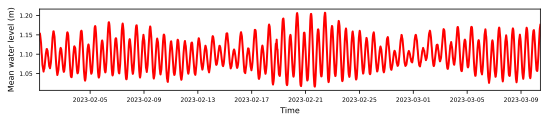

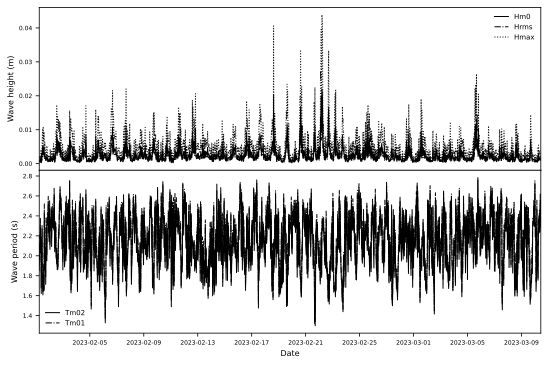

In [36]:
fig, ax0 = plt.subplots(figsize=(9,1.5), nrows=1, sharex=True, 
                        gridspec_kw={'hspace': 0})
ax0.plot(Wwave_time, mean_pressure, lw=2, c='red')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Mean water level (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
plt.xlim(Wwave_time[0],Wwave_time[-1])
plt.show()

plt.rc('legend',**{'fontsize':7})

fig, (ax0, ax1) = plt.subplots(figsize=(9,6), nrows=2, sharex=True, 
                               gridspec_kw={'hspace': 0.})
ax0.plot(Wwave_time, W_Hm0, lw=1, c='k', label='Hm0')
ax0.plot(Wwave_time, W_Hrms, lw=1, c='k', ls='-.', label='Hrms')
ax0.plot(Wwave_time, W_Hmax, lw=1, c='k', ls=':', label='Hmax')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Wave height (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
ax0.legend(loc=0,frameon=False)

ax1.plot(Wwave_time, W_Tm02, lw=1, c='k', label='Tm02')
ax1.plot(Wwave_time, W_Tm01, lw=1, c='k', ls='-.', label='Tm01')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Wave period (s)', fontsize=8)
plt.xlabel('Date', fontsize=8)
plt.xlim(Wwave_time[0],Wwave_time[-1])
ax1.legend(loc=0,frameon=False)

plt.show()

Plot Swell waves:

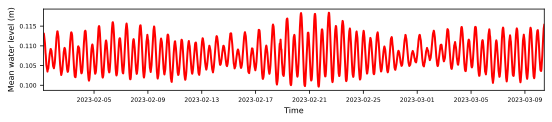

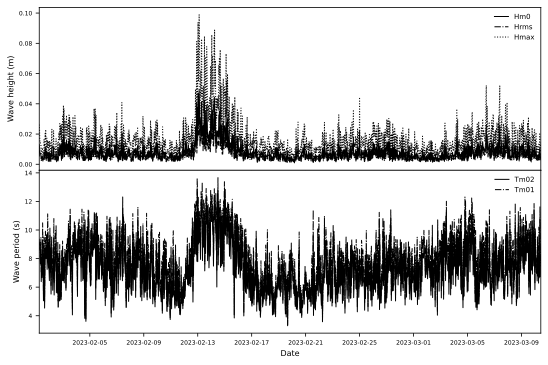

In [38]:
fig, ax0 = plt.subplots(figsize=(9,1.5), nrows=1, sharex=True, 
                        gridspec_kw={'hspace': 0})
ax0.plot(Gwave_time, mean_pressure, lw=2, c='red')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Mean water level (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
plt.xlim(Gwave_time[0],Gwave_time[-1])
plt.show()

plt.rc('legend',**{'fontsize':7})

fig, (ax0, ax1) = plt.subplots(figsize=(9,6), nrows=2, sharex=True, 
                               gridspec_kw={'hspace': 0.})
ax0.plot(Gwave_time, G_Hm0, lw=1, c='k', label='Hm0')
ax0.plot(Gwave_time, G_Hrms, lw=1, c='k', ls='-.', label='Hrms')
ax0.plot(Gwave_time, G_Hmax, lw=1, c='k', ls=':', label='Hmax')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Wave height (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
ax0.legend(loc=0,frameon=False)

ax1.plot(Gwave_time, G_Tm02, lw=1, c='k', label='Tm02')
ax1.plot(Gwave_time, G_Tm01, lw=1, c='k', ls='-.', label='Tm01')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Wave period (s)', fontsize=8)
plt.xlabel('Date', fontsize=8)
plt.xlim(Gwave_time[0],Gwave_time[-1])
ax1.legend(loc=0,frameon=False)

plt.show()

Plot infragravity waves:

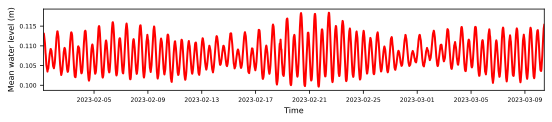

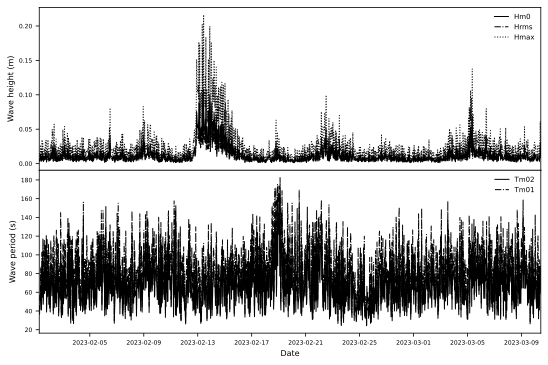

In [39]:
fig, ax0 = plt.subplots(figsize=(9,1.5), nrows=1, sharex=True, 
                        gridspec_kw={'hspace': 0})
ax0.plot(IGwave_time, mean_pressure, lw=2, c='red')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Mean water level (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
plt.xlim(Gwave_time[0],Gwave_time[-1])
plt.show()

plt.rc('legend',**{'fontsize':7})

fig, (ax0, ax1) = plt.subplots(figsize=(9,6), nrows=2, sharex=True, 
                               gridspec_kw={'hspace': 0.})
ax0.plot(IGwave_time, IG_Hm0, lw=1, c='k', label='Hm0')
ax0.plot(IGwave_time, IG_Hrms, lw=1, c='k', ls='-.', label='Hrms')
ax0.plot(IGwave_time, IG_Hmax, lw=1, c='k', ls=':', label='Hmax')
ax0.tick_params(axis='both', which='major', labelsize=6)
ax0.set_ylabel('Wave height (m)', fontsize=8)
plt.xlabel('Time', fontsize=8)
ax0.legend(loc=0,frameon=False)

ax1.plot(IGwave_time, IG_Tm02, lw=1, c='k', label='Tm02')
ax1.plot(IGwave_time, IG_Tm01, lw=1, c='k', ls='-.', label='Tm01')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Wave period (s)', fontsize=8)
plt.xlabel('Date', fontsize=8)
plt.xlim(IGwave_time[0],IGwave_time[-1])
ax1.legend(loc=0,frameon=False)

plt.show()

Plot all waves together:

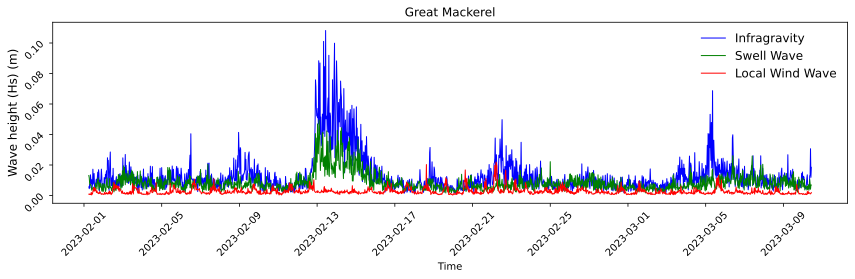

In [40]:
plt.rc('legend',**{'fontsize':7})

fig, (ax0) = plt.subplots(figsize=(12,4), nrows=1, sharex=True, 
                               gridspec_kw={'hspace': 0.})
ax0.plot(IGwave_time, IG_Hm0, lw=1, c='b', label='Infragravity')
ax0.plot(IGwave_time, G_Hm0, lw=1, c='g', label='Swell Wave')
ax0.plot(IGwave_time, W_Hm0, lw=1, c='r', label='Local Wind Wave')
ax0.tick_params(axis='both', which='major', labelsize=10,rotation=45)
ax0.set_ylabel('Wave height (Hs) (m)', fontsize=12)
plt.xlabel('Time', fontsize=10)
plt.title('Great Mackerel')
ax0.legend(loc=0,frameon=False,fontsize=12)

plt.tight_layout()
plt.savefig("GM.png", dpi=300)
plt.show()

Plot energy spectra:

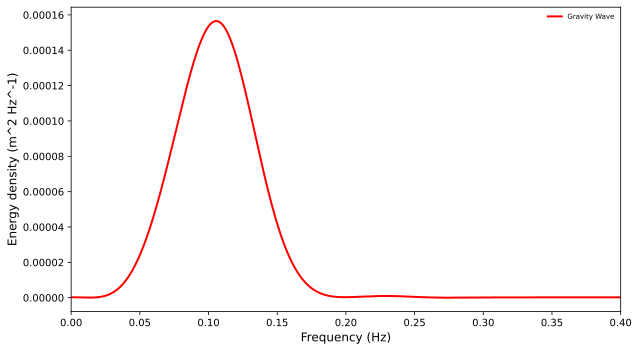

In [41]:
fig, ax0 = plt.subplots(figsize=(9,5), nrows=1, sharex=True, 
                        gridspec_kw={'hspace': 0})
ax0.plot(G_fspec, G_s, lw=2, c='r', label='Gravity Wave')
#ax0.plot(IG_fspec, IG_s, lw=2, c='r', label='infragravity wave')
#ax0.plot(W_fspec, W_s, lw=2, c='b', label='wind wave')
ax0.tick_params(axis='both', which='major', labelsize=10)
ax0.set_ylabel('Energy density (m^2 Hz^-1)', fontsize=12)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.xlim(G_fspec.min(),G_fspec.max())
plt.xlim(0,0.4)
ax0.legend(loc=1,frameon=False)

plt.tight_layout()
plt.savefig("GM_G.png", dpi=300)
plt.show()

Plot energy spectra with cut off frequency:

C:\Users\mgaz4900\AppData\Local\Temp\ipykernel_13476\4192972849.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


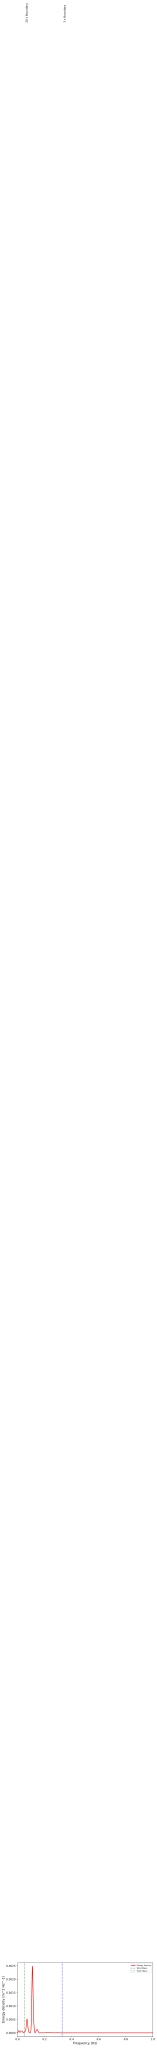

In [32]:
fig, ax0 = plt.subplots(figsize=(9,5), nrows=1, sharex=True, 
                        gridspec_kw={'hspace': 0})
ax0.plot(G_fspec, G_s, lw=2, c='r', label='Energy Spectra')
#ax0.plot(IG_fspec, IG_s, lw=2, c='r', label='infragravity wave')
#ax0.plot(W_fspec, W_s, lw=2, c='b', label='wind wave')
ax0.tick_params(axis='both', which='major', labelsize=10)
ax0.set_ylabel('Energy density (m^2 Hz^-1)', fontsize=12)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.xlim(G_fspec.min(),G_fspec.max())
plt.xlim(0,1)
ax0.legend(loc=1,frameon=False)

plt.axvline(x=0.33, ls=':', lw=2, color='b', label='Wind Wave')
plt.axvline(x=0.05, ls=':', lw=2, color='g', label='Swell Wave')
plt.text(0.34,0.075,'3 s Boundary',rotation=90)
plt.text(0.06,0.075,'20 s Boundary',rotation=90)
plt.legend()


plt.tight_layout()
plt.savefig("GM_G.png", dpi=300)
plt.show()